This is part of the July, tabular competition where I was ranked 9th (top 1%): https://www.kaggle.com/competitions/tabular-playground-series-jul-2022.

This is an example of using unsupervised techniques to find meaningful clusters

<div class="alert alert-success">  
</div>

In [1]:
import warnings # suppress warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import gc
import random

import numpy as np 
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy import stats
from pathlib import Path

import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
!ls ../input/*

../input/feat-eng-10-models:
submission_feat_eng_10_models.csv

../input/tabular-playground-series-jul-2022:
data.csv  sample_submission.csv

../input/tps22jul81580:
submission.csv

../input/tps22jul81661:
submission.csv

../input/tps22jun81232:
submission.csv


In [3]:
!pip install sklego

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.1/224.1 kB 843.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.0 MB/s eta 0:00:00


In [4]:
from sklego.mixture import BayesianGMMClassifier
from sklearn.mixture import BayesianGaussianMixture

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler, RobustScaler, LabelEncoder

<div>
    <h1 align="center" style="color:darkgreen;">Load Data & Preprocessing</h1>
</div>

<div class="alert alert-success">  
</div>

In [5]:
DATA = pd.read_csv('../input/tabular-playground-series-jul-2022/data.csv')
SAMPLE = pd.read_csv('../input/tabular-playground-series-jul-2022/sample_submission.csv')

In [6]:
df = DATA.copy()
df.drop("id", axis=1, inplace=True)
cols = list(df.columns)

In [7]:
df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,5,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,13,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,5,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [8]:
# a = (10e14)
# b = (10e12)
# c = (10e10)
# d = (10e8)
# e = (10e6)
# f = (10e4)
# g = (10e2)

In [9]:
# df['feat_1'] = (a * df['f_07'] + b * df['f_08'] + c * df['f_09'] + d * df['f_10'] + e * df['f_11'] + f * df['f_12'] + g * df['f_13'])/a
# df['feat_2'] = (a * df['f_13'] + b * df['f_07'] + c * df['f_08'] + d * df['f_09'] + e * df['f_10'] + f * df['f_11'] + g * df['f_12'])/a
# df['feat_3'] = (a * df['f_12'] + b * df['f_13'] + c * df['f_07'] + d * df['f_08'] + e * df['f_09'] + f * df['f_10'] + g * df['f_11'])/a
# df['feat_4'] = (a * df['f_11'] + b * df['f_12'] + c * df['f_13'] + d * df['f_07'] + e * df['f_08'] + f * df['f_09'] + g * df['f_10'])/a
# df['feat_5'] = (a * df['f_10'] + b * df['f_11'] + c * df['f_12'] + d * df['f_13'] + e * df['f_07'] + f * df['f_08'] + g * df['f_09'])/a
# df['feat_6'] = (a * df['f_09'] + b * df['f_10'] + c * df['f_11'] + d * df['f_12'] + e * df['f_13'] + f * df['f_07'] + g * df['f_08'])/a
# df['feat_7'] = (a * df['f_08'] + b * df['f_09'] + c * df['f_10'] + d * df['f_11'] + e * df['f_12'] + f * df['f_13'] + g * df['f_07'])/a

In [10]:
cols_select = []
alpha = 0.005

for col in cols:
    _, p_value = stats.shapiro(df[col])
    
    if (p_value <= alpha): 
        cols_select.append(col)
# cols_select = ['feat_1','feat_2','feat_3','feat_4','feat_5','feat_6','feat_7', 'f_22','f_23', 'f_24', 'f_25','f_26','f_27', 'f_28']
print(cols_select)  

['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']


# <span style="color:darkgreen;">Scaling</span>

In [11]:
dff = df[cols_select]

dffs = dff.copy()
dffs = PowerTransformer().fit_transform(dffs)
dffs = pd.DataFrame(dffs, columns=cols_select)
dffs

,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.977987,1.383372,1.039938,-0.567775,1.142180,-0.083596,0.086073,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234
1,-0.977987,-0.875405,-0.179925,-0.837020,-0.420725,1.725834,0.738456,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652
2,0.021718,1.017648,-0.394246,0.124844,0.296135,-0.928325,1.118063,2.203065,0.086974,-1.519163,-0.568662,0.978900,-0.926277,-2.296373
3,0.286548,-1.213526,0.917564,0.124844,0.296135,-0.083596,-0.434221,0.731623,-1.218086,0.826492,-1.173592,-0.395085,-0.100021,0.326682
4,0.756900,0.187543,-0.394246,-1.135381,-1.954502,1.271662,1.118063,0.228337,-1.482684,0.847999,-0.613935,1.164389,-0.374203,-1.160058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97995,0.021718,0.187543,0.191659,-0.567775,-0.171515,-0.083596,0.317221,0.952876,0.407860,1.283842,-0.075219,-0.989846,0.166988,0.459507
97996,-0.598123,0.622133,-1.243439,-0.567775,-1.259638,0.936024,1.295599,1.158978,-0.429211,0.271421,0.783851,0.141914,0.692651,0.639735
97997,0.756900,0.622133,0.509344,-0.090749,-0.682876,-0.614590,-0.735370,-0.995900,1.450009,0.867108,0.180931,1.539188,1.178636,0.584929
97998,-1.440987,0.410491,0.653205,0.706932,-1.259638,0.565556,-0.162832,0.278189,0.512721,0.687465,-0.286145,-1.085469,-0.538491,0.129094


<div>
    <h1 align="center" style="color:darkgreen;">Ensembling with BayesianGMMClassifier</h1>
</div>

<div class="alert alert-success">  
</div>

In [12]:
sub_prime = pd.read_csv('../input/tps22jul81580/submission.csv', index_col=[0])
sub_prime['Predicted'].value_counts()

3    16358
5    16343
6    14699
1    13775
4    13018
7    12524
2    11283
Name: Predicted, dtype: int64

2    16358
4    16343
5    14699
0    13775
3    13018
6    12524
1    11283
Name: Predicted, dtype: int64

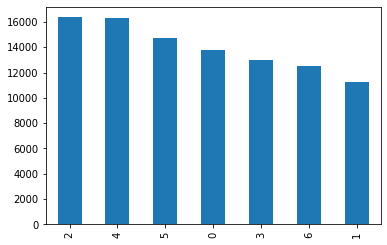

In [13]:
sub_prime['Predicted'] += -1

sub_prime['Predicted'].value_counts().plot(kind='bar')
sub_prime['Predicted'].value_counts()

In [14]:
support1 = pd.read_csv('../input/tps22jul81661/submission.csv', index_col=[0])
support1['Predicted'].value_counts()

3    16778
1    15776
5    15063
2    14217
6    12855
4    11935
7    11376
Name: Predicted, dtype: int64

2    16778
0    15776
4    15063
1    14217
5    12855
3    11935
6    11376
Name: Predicted, dtype: int64

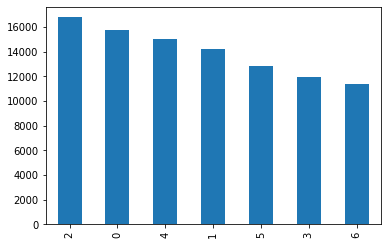

In [15]:
support1['Predicted'] += -1

support1['Predicted'].value_counts().plot(kind='bar')
support1['Predicted'].value_counts()

In [16]:
support2 = pd.read_csv('../input/tps22jun81232/submission.csv', index_col=[0])
support2['Predicted'].value_counts()

4    16355
5    16331
2    14769
1    13701
6    12988
3    12532
7    11324
Name: Predicted, dtype: int64

3    16355
4    16331
1    14769
0    13701
5    12988
2    12532
6    11324
Name: Predicted, dtype: int64

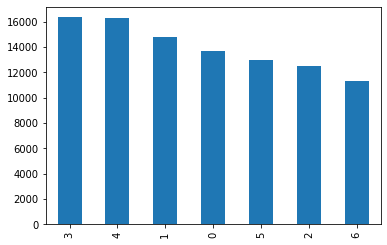

In [17]:
support2['Predicted'] += -1

support2['Predicted'].value_counts().plot(kind='bar')
support2['Predicted'].value_counts()

In [18]:
support3 = pd.read_csv('../input/feat-eng-10-models/submission_feat_eng_10_models.csv', index_col=[0])
support3['Predicted'].value_counts()



1    16408
3    16318
5    14711
2    13777
6    12998
4    12487
7    11301
Name: Predicted, dtype: int64

0    16408
2    16318
4    14711
1    13777
5    12998
3    12487
6    11301
Name: Predicted, dtype: int64

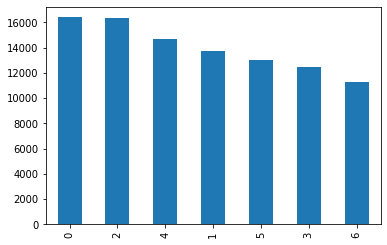

In [19]:
support3['Predicted'] += -1

support3['Predicted'].value_counts().plot(kind='bar')
support3['Predicted'].value_counts()

<div class="alert alert-success">  
</div>

In [20]:
X = np.array(dffs)
y = np.array(sub_prime)

s1 = np.array(support1)
s2 = np.array(support2)
s3 = np.array(support3)

In [21]:
bgm = BayesianGMMClassifier(n_components=7, random_state=1234, tol=0.001, max_iter=300, n_init=3, verbose=0)

bgm.fit(X,y)
proba = bgm.predict_proba(X)

bgm.fit(X,s1)
probs1 = bgm.predict_proba(X)

bgm.fit(X,s2)
probs2 = bgm.predict_proba(X)

bgm.fit(X,s3)
probs3 = bgm.predict_proba(X)

proba.shape, probs1.shape, probs2.shape, probs3.shape

((98000, 7), (98000, 7), (98000, 7), (98000, 7))

<div class="alert alert-success">  
</div>

### <span style="color:darkgreen;">We multiply the probabilities in the support notebooks by appropriate coefficients.</span>

In [22]:
prob = np.concatenate((proba, probs1*0.99), axis=1)
# prob = np.concatenate((prob,  probs2*0.93), axis=1)
prob = np.concatenate((prob,  probs3*0.9), axis=1)
prob.shape

(98000, 21)

### <span style="color:darkgreen;">The final result is the highest probability (related to each of the algorithms).</span>

In [23]:
pred = np.argmax(prob, axis=1)
pred, min(pred), max(pred)

(array([ 0,  6,  5, ..., 11,  1,  4]), 0, 20)

<div class="alert alert-success">  
</div>

In [24]:
clusters = np.zeros(shape=(7, 7), dtype=int)
for n1, n2 in zip(y, s1):
    clusters[n1, n2] += 1
    
clusters

array([[   33, 13518,    70,    24,    81,    10,    39],
       [   31,    23,    48,    24,    12,    15, 11130],
       [   30,    20, 16149,    33,    65,    34,    27],
       [   10,    10,    93,    66,   167, 12651,    21],
       [15613,   521,    60,    29,    10,    15,    95],
       [    7,    27,    78,    27, 14448,    86,    26],
       [   52,    98,   280, 11732,   280,    44,    38]])

In [25]:
max_clusters = np.argmax(clusters, axis=0)
max_clusters

array([4, 0, 2, 6, 5, 3, 1])

In [26]:
for i in range(len(pred)):
    
    if (pred[i] == 7): 
        pred[i] = max_clusters[0]
    if (pred[i] == 8): 
        pred[i] = max_clusters[1]
    if (pred[i] == 9): 
        pred[i] = max_clusters[2]
    if (pred[i] == 10): 
        pred[i] = max_clusters[3]
    if (pred[i] == 11): 
        pred[i] = max_clusters[4]
    if (pred[i] == 12): 
        pred[i] = max_clusters[5]
    if (pred[i] == 13): 
        pred[i] = max_clusters[6]        

pred, min(pred), max(pred)

(array([0, 6, 5, ..., 5, 1, 4]), 0, 20)

In [27]:
#for i in range(len(pred)):   
    #for j in range(7, 14):
        #if (pred[i] == j):  
            #pred[i] = max_clusters[j-7]

<div class="alert alert-success">  
</div>

In [28]:
# clusters = np.zeros(shape=(7, 7), dtype=int)
# for n1, n2 in zip(y, s2):
#     clusters[n1, n2] += 1
    
# clusters

In [29]:
# max_clusters = np.argmax(clusters, axis=0)
# max_clusters

In [30]:
# for i in range(len(pred)):
    
#     if (pred[i] == 14): 
#         pred[i] = max_clusters[0]
#     if (pred[i] == 15): 
#         pred[i] = max_clusters[1]
#     if (pred[i] == 16): 
#         pred[i] = max_clusters[2]
#     if (pred[i] == 17): 
#         pred[i] = max_clusters[3]
#     if (pred[i] == 18): 
#         pred[i] = max_clusters[4]
#     if (pred[i] == 19): 
#         pred[i] = max_clusters[5]
#     if (pred[i] == 20): 
#         pred[i] = max_clusters[6]        

# pred, min(pred), max(pred)

## Pablo

In [31]:
clusters = np.zeros(shape=(7, 7), dtype=int)
for n1, n2 in zip(y, s3):
    clusters[n1, n2] += 1
    
clusters

array([[   43, 13556,    41,    42,    49,     6,    38],
       [   31,    29,    61,    32,    12,     8, 11110],
       [16056,    43,    45,    89,    58,    29,    38],
       [   34,     2,     4,    29,    58, 12888,     3],
       [   42,    60, 16119,    41,     7,     7,    67],
       [   87,    46,    10,    65, 14435,    41,    15],
       [  115,    41,    38, 12189,    92,    19,    30]])

In [32]:
max_clusters = np.argmax(clusters, axis=0)
max_clusters

array([2, 0, 4, 6, 5, 3, 1])

In [33]:
for i in range(len(pred)):
    
    if (pred[i] == 14): 
        pred[i] = max_clusters[0]
    if (pred[i] == 15): 
        pred[i] = max_clusters[1]
    if (pred[i] == 16): 
        pred[i] = max_clusters[2]
    if (pred[i] == 17): 
        pred[i] = max_clusters[3]
    if (pred[i] == 18): 
        pred[i] = max_clusters[4]
    if (pred[i] == 19): 
        pred[i] = max_clusters[5]
    if (pred[i] == 20): 
        pred[i] = max_clusters[6]        

pred, min(pred), max(pred)

(array([0, 6, 5, ..., 5, 1, 4]), 0, 6)

<div>
    <h1 align="center" style="color:darkgreen;">Submission</h1>
</div>

<div class="alert alert-success">  
</div>

In [34]:
sub = SAMPLE.copy()
sub['Predicted'] = pred

In [35]:
hist_data = [sub_prime.iloc[:, 0], pred]  
group_labels = ['Sub_Prime', 'Submission']
  
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2, show_hist=False, show_rug=False) 
fig.show()

In [36]:
sub.to_csv("submission_with_new_feat.csv", index=False)
!ls

__notebook_source__.ipynb  submission_with_new_feat.csv
